# Preprocessing in Remote Sensing: Reprojection, Alignment and Clipping

---

This section outlines three fundamental preprocessing operations required to ensure the spatial consistency of geospatial raster datasets:

- **Reprojection** involves transforming raster data from one spatial reference system to another (e.g., from EPSG:4326 to EPSG:32633). This is essential when combining datasets that use different coordinate systems.

- **Alignment** ensures that two or more raster images are coregistered, meaning their pixel grids are spatially matched with identical origins, resolutions, and extents. Misalignment at the pixel level can introduce artifacts or errors in pixel-wise operations.

- **Clipping** is a geospatial operation that extracts a portion of spatial data based on a specified boundary or shape.

In the example below, we will use [***T59GPM_20190305T222531_B03_20m.jp2***](https://browser.dataspace.copernicus.eu) band which can be found on copernicus.

---

## Import

In [10]:
from osgeo import gdal,osr,ogr
gdal.UseExceptions()

import numpy as np
import matplotlib.pyplot as plt

---
## Reprojection

For this example, we change the CRS with gdal.Warp.

In [ ]:
ds=gdal.Warp(
    destNameOrDestDS="T59GPM_new_proj.tif",
    srcDSOrSrcDSTab="T59GPM_20190305T222531_B03_20m.jp2",   
    dstSRS="EPSG:32632", 
    format="GTiff"
)
ds=None

If we want to see the CRS or all the data related to a file, we can use gdal.Info

In [ ]:
info = gdal.Info("T59GPM_new_proj.tif")

# Line by line display
for line in info.splitlines():
    print(line)

---
## Alignement

Before realigned our raster, we need to modified it for education purpose. To do so, we change some values on the geotransform argument. 

Geotransform example : gt = (500000.0, 20.0, 0.0, 4600000.0, 0.0, -20.0)

- gt[0] -> Origin X (minX): X coordinate of the top-left corner
- gt[1] -> Pixel width (x resolution): size of a pixel in the X direction
- gt[2] -> Rotation X (usually 0): pixel rotation around the X axis (row-wise skew)
- gt[3] -> Origin Y (maxY): Y coordinate of the top-left corner
- gt[4] -> Rotation Y (usually 0): pixel rotation around the Y axis (column-wise skew)
- gt[5] -> Pixel height (y resolution): size of a pixel in the Y direction (usually negative)

We will add 50 000 to the gt[0]. This will create a 50 000 m shift toward east (Meter because we are in UTM). But you can also change gt[3] or else if you want.

In [ ]:
# Ref Raster + 50 000m toward east
ds = gdal.Open("T59GPM_20190305T222531_B03_20m.jp2", gdal.GA_ReadOnly)
array = ds.ReadAsArray()
gt = list(ds.GetGeoTransform())  # conversion tuple → editable list
proj = ds.GetProjection()
cols, rows = ds.RasterXSize, ds.RasterYSize
dtype = ds.GetRasterBand(1).DataType
gt[0] += 50000   # 50 000m toward East because we have an UTM CRS
ds = None

# Creation of the shifted raster
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create("T59GPM_shifted.tif", cols, rows, 1, dtype)
out_ds.SetGeoTransform(gt)
out_ds.SetProjection(proj)
out_ds.GetRasterBand(1).WriteArray(array)
out_ds.FlushCache()
out_ds = None

Next, we will see a method to get a spatial alignment. First, we need to know the reference grid (geotransform,pixel resolution and projection). After, we will use *gdal.warp*.

In [9]:
# Ref
ref_ds = gdal.Open("T59GPM_20190305T222531_B03_20m.jp2")
gt_ref = ref_ds.GetGeoTransform()
proj_ref = ref_ds.GetProjection()
xres = gt_ref[1]
yres = abs(gt_ref[5])
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize
bounds = (
    gt_ref[0],
    gt_ref[3] + rows * gt_ref[5],
    gt_ref[0] + cols * xres,
    gt_ref[3]
)
ref_ds=None

# Gdal.Warp
warp_options = gdal.WarpOptions(
    format="GTiff",
    dstSRS=proj_ref,
    xRes=xres,
    yRes=yres,
    targetAlignedPixels=True,
    outputBounds=bounds,
    outputBoundsSRS=proj_ref,
    resampleAlg='bilinear'
)
ds=gdal.Warp(
    destNameOrDestDS="T59GPM_realigned.tif",
    srcDSOrSrcDSTab="T59GPM_shifted.tif",
    options=warp_options
)
ds=None

Below, we display the result. We see that gdal.warp only realigned spatialy and not slide the array to the grid ref.

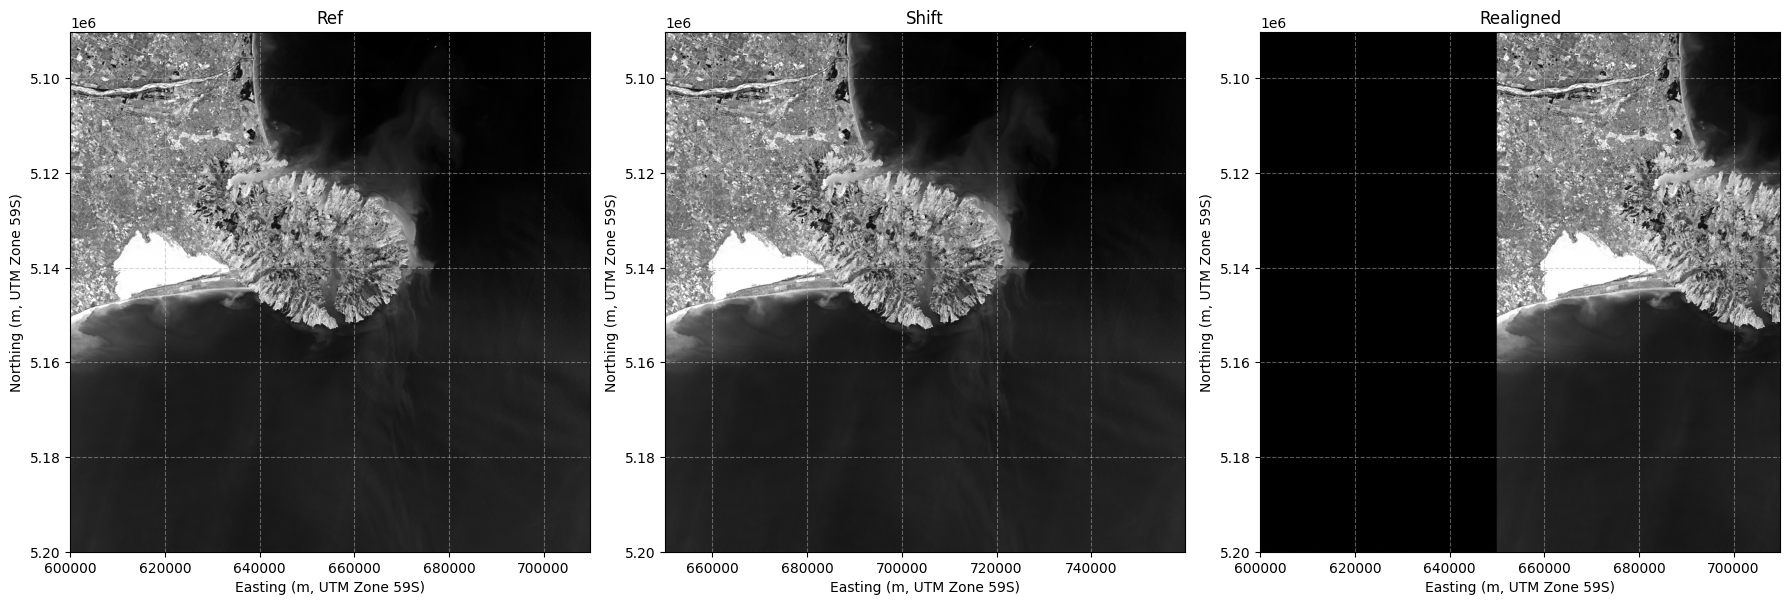

In [ ]:
def read_and_stretch(path, vmin=None, vmax=None, pmin=2, pmax=98):
    """
    Reads a raster file, computes its spatial extent, and applies contrast stretching 
    based on given or percentile-based min and max values.

    Returns the stretched array (scaled 0-1), extent tuple, and used min/max values.
    """
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    gt = ds.GetGeoTransform()
    cols, rows = ds.RasterXSize, ds.RasterYSize
    ds = None   
    extent = ( gt[0], gt[0] + cols * gt[1], gt[3],gt[3] + rows * gt[5])     # xmin, xmax, ymin, ymax
    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(array, (pmin, pmax))
    stretched = np.clip((array - vmin) / (vmax - vmin), 0, 1)
    return stretched, extent, vmin, vmax

# We want the same stretch for all raster. So all the raster have ref_stretch
ref_path = "T59GPM_20190305T222531_B03_20m.jp2"
shift_path = "T59GPM_shifted.tif"
aligned_path = "T59GPM_realigned.tif"

ref_img, ref_extent, vmin, vmax = read_and_stretch(ref_path)
shift_img, shift_extent,_,_ = read_and_stretch(shift_path, vmin, vmax)
aligned_img, aligned_extent, _, _ = read_and_stretch(aligned_path, vmin, vmax)

# Display
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Ref", "Shift", "Realigned"]
images = [(ref_img, ref_extent), (shift_img, shift_extent), (aligned_img, aligned_extent)]

for ax, (img, extent), title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray', extent=extent)
    ax.set_title(title)
    ax.set_xlabel("Easting (m, UTM Zone 59S)")
    ax.set_ylabel("Northing (m, UTM Zone 59S)")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


---

## Cliping

Now, we are going to see how to clip the tif *T59GPM_20190305T222531_B03_20m.jp2* with a square shapefile.

First, we create a 20km*20km square using ogr, the vector engine of GDAL.

In [20]:
ds = gdal.Open("T59GPM_20190305T222531_B03_20m.jp2")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()
cols = ds.RasterXSize
rows = ds.RasterYSize
ds=None
# Finding the center coordinates
x_center = gt[0] + (cols / 2) * gt[1]
y_center = gt[3] + (cols / 2) * gt[5]
# We define the size of the square in meter
size = 10000  # half-size -> 10 000 m = square 20km*20km
x_min = x_center - size
x_max = x_center + size
y_min = y_center - size
y_max = y_center + size
# Set projection, the same as ds
srs = osr.SpatialReference()
srs.ImportFromWkt(proj)
# Shapefile creation
driver = ogr.GetDriverByName("ESRI Shapefile")
shp_ds = driver.CreateDataSource("square.shp")
layer = shp_ds.CreateLayer("square", srs, ogr.wkbPolygon)
field = ogr.FieldDefn("id", ogr.OFTInteger)
layer.CreateField(field)
# Polygon creation
ring = ogr.Geometry(ogr.wkbLinearRing)
ring.AddPoint(x_min, y_min)
ring.AddPoint(x_min, y_max)
ring.AddPoint(x_max, y_max)
ring.AddPoint(x_max, y_min)
ring.AddPoint(x_min, y_min) # # we return to the starting point to close the polygon 
polygon = ogr.Geometry(ogr.wkbPolygon)
polygon.AddGeometry(ring)
feature_defn = layer.GetLayerDefn()
feature = ogr.Feature(feature_defn)
feature.SetGeometry(polygon)
feature.SetField("id", 1)
layer.CreateFeature(feature)

feature = None
shp_ds = None


Second, we use gdal.warp to clip the raster and the shapefile. In addition, we create an alpha band who contain the pixel outside the cutline and they will be transparent. We also set the nodata values to -9999.

In [14]:
warp_options = gdal.WarpOptions(
    format="GTiff",
    cutlineDSName="square.shp",
    cropToCutline=True,
    dstNodata=-9999,
    dstAlpha=True
)
ds=gdal.Warp(
    destNameOrDestDS="T59GPM_square.tif",
    srcDSOrSrcDSTab="T59GPM_20190305T222531_B03_20m.jp2",
    options=warp_options
)
ds=None

Below, we display the result.

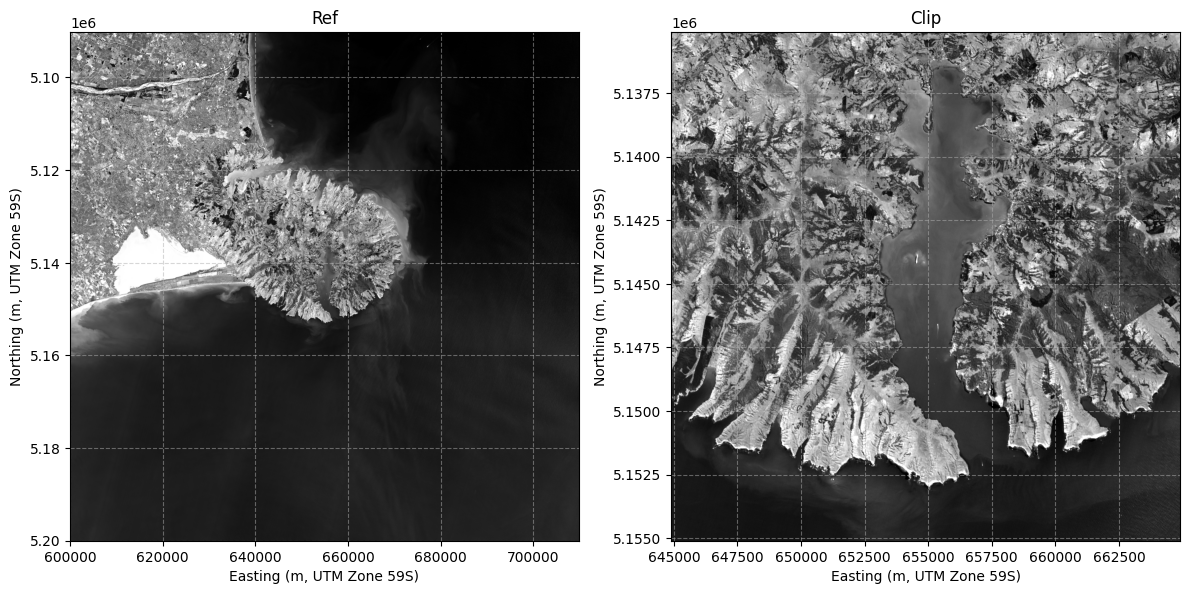

In [15]:
def read_and_stretch(path, vmin=None, vmax=None, pmin=2, pmax=98):
    """
    Reads a raster file, computes its spatial extent, and applies contrast stretching 
    based on given or percentile-based min and max values.

    Returns the stretched array (scaled 0-1), extent tuple, and used min/max values.
    """
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    gt = ds.GetGeoTransform()
    cols, rows = ds.RasterXSize, ds.RasterYSize
    ds = None   
    extent = ( gt[0], gt[0] + cols * gt[1], gt[3],gt[3] + rows * gt[5])     # xmin, xmax, ymin, ymax
    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(array, (pmin, pmax))
    stretched = np.clip((array - vmin) / (vmax - vmin), 0, 1)
    return stretched, extent, vmin, vmax

# We want the same stretch for all raster. So all the raster have ref_stretch
ref_path = "T59GPM_20190305T222531_B03_20m.jp2"
size_path = "T59GPM_square.tif"

ref_img, ref_extent, vmin, vmax = read_and_stretch(ref_path)
size_img, size_extent,_,_ = read_and_stretch(size_path, vmin, vmax)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ref", "Clip"]
images = [(ref_img, ref_extent), (size_img, size_extent)]

for ax, (img, extent), title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray', extent=extent)
    ax.set_title(title)
    ax.set_xlabel("Easting (m, UTM Zone 59S)")
    ax.set_ylabel("Northing (m, UTM Zone 59S)")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
